
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 多層パーセプトロンの実装

:label: `sec_mlp-implementation`

多層パーセプトロン (MLP) は、単純な線形モデルと比べて実装がそれほど複雑ではありません。概念的な主な違いは、複数のレイヤーを連結していることです。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


## ゼロからの実装

このようなネットワークを最初から実装してみましょう。

### モデルパラメータの初期化

Fashion-MNIST には 10 のクラスが含まれており、各画像はグレースケール ピクセル値の $28 \times 28 = 784$ グリッドで構成されていることを思い出してください。以前と同様に、今のところピクセル間の空間構造を無視するため、これを 784 の入力フィーチャと 10 のクラスを含む分類データセットとして考えることができます。まず、[ **1 つの隠れ層と 256 の隠れユニットを持つ MLP を実装します。** ] レイヤーの数とその幅は両方とも調整可能です (これらはハイパーパラメーターとみなされます)。通常、レイヤー幅は 2 の大きい累乗で割り切れるように選択します。これは、ハードウェアでメモリが割り当てられアドレス指定される方法により、計算効率が高くなります。

もう一度、パラメータをいくつかのテンソルで表します。*すべての層について*、1 つの重み行列と 1 つのバイアス ベクトルを追跡する必要があることに注意してください。いつものように、これらのパラメータに関する損失の勾配にメモリを割り当てます。



以下のコードでは[`nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)を使用して、 `autograd` (:numref: `sec_autograd` ) によって追跡されるパラメーターとしてクラス属性を自動的に登録します。


In [2]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))


### モデル

すべてがどのように機能するかを確認するために、組み込みの`relu`関数を直接呼び出すのではなく、自分たちで [ **ReLU アクティベーションを実装**] します。


In [3]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)


空間構造を無視しているため、各 2 次元画像を長さ`num_inputs`の平面ベクトルに`reshape` 。最後に、わずか数行のコードで**モデルを実装します**。 autograd に組み込まれているフレームワークを使用しているので、必要なのはこれだけです。


In [4]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2


### トレーニング

幸いなことに、[ **MLP のトレーニング ループはソフトマックス回帰の場合とまったく同じです。** ] モデル、データ、トレーナーを定義し、最後にモデルとデータに対して`fit`メソッドを呼び出します。


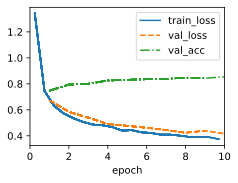

In [5]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)


## 簡潔な実装

ご想像のとおり、高レベル API を利用することで、MLP をさらに簡潔に実装できます。

### モデル

ソフトマックス回帰実装の簡潔な実装 (:numref: `sec_softmax_concise` ) と比較すると、唯一の違いは、以前は*1 つだけ*追加していた完全に接続された層を*2 つ*追加することです。 1 つ目は [**隠れ層**]、2 つ目は出力層です。


In [6]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))


以前は、モデル パラメーターを使用して入力を変換するためのモデルの`forward`メソッドを定義しました。これらの操作は本質的にパイプラインです。入力を取得して変換 (たとえば、重みを伴う行列の乗算とそれに続くバイアス加算) を適用し、現在の変換の出力を次の変換への入力として繰り返し使用します。ただし、ここでは`forward`メソッドが定義されていないことに気づいたかもしれません。実際、 `MLP` `Module`クラス (:numref: `subsec_oo-design-models` ) から`forward`メソッドを継承して、 `self.net(X)` ( `X`は入力) を呼び出すだけです。これは現在、 `Sequential`クラスを介した一連の変換として定義されています。 。 `Sequential`クラスは前方プロセスを抽象化し、変換に集中できるようにします。 `Sequential`クラスが :numref: `subsec_model-construction-sequential`でどのように機能するかについてさらに説明します。

### トレーニング

[**トレーニング ループ**] は、ソフトマックス回帰を実装したときとまったく同じです。このモジュール性により、モデル アーキテクチャに関する事項を直交的な考慮事項から分離することができます。


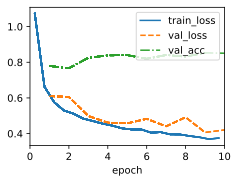

In [7]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)


## まとめ

ディープ ネットワークの設計をより実践できるようになった今では、ディープ ネットワークの単一レイヤーから複数レイヤーへのステップはそれほど大きな課題ではなくなりました。特に、トレーニング アルゴリズムとデータ ローダーを再利用できます。ただし、MLP を最初から実装するのは面倒であることに注意してください。名前を付けたり、モデル パラメーターを追跡したりすると、モデルの拡張が困難になります。たとえば、レイヤー 42 と 43 の間に別のレイヤーを挿入したいとします。順次名前変更を実行しない限り、これはレイヤー 42b になる可能性があります。さらに、ネットワークを最初から実装する場合、フレームワークが有意義なパフォーマンスの最適化を実行することははるかに困難になります。

それにもかかわらず、完全に接続されたディープ ネットワークがニューラル ネットワーク モデリングの最適な方法であった 1980 年代後半の最先端の技術に到達しました。次の概念的なステップは、画像を検討することです。その前に、モデルを効率的に計算する方法に関する多くの統計の基本と詳細を確認する必要があります。

## 演習
1. 隠れユニット`num_hiddens`の数を変更し、その数がモデルの精度にどのような影響を与えるかをプロットします。このハイパーパラメータの最適な値はどれですか?
1. 非表示レイヤーを追加して、結果にどのような影響を与えるかを確認してください。
1. 単一のニューロンを含む隠れ層を挿入するのはなぜ悪い考えなのでしょうか?何が問題になる可能性がありますか?
1. 学習率を変更すると結果はどう変わりますか?他のパラメータがすべて固定されている場合、どの学習率が最良の結果をもたらしますか?これはエポック数とどのように関係するのでしょうか?
1. すべてのハイパーパラメータ、つまり学習率、エポック数、隠れ層の数、層ごとの隠れユニットの数を合わせて最適化してみましょう。<ol><li>これらすべてを最適化することで得られる最良の結果は何でしょうか?
1. 複数のハイパーパラメータを扱うことがはるかに難しいのはなぜでしょうか?
1. 複数のパラメーターを組み合わせて最適化するための効率的な戦略を説明します。
1. これは GPU と CPU の間でどのように変化しますか?
1.  CPU と GPU のメモリ バス幅を決定します。



[ディスカッション](https://discuss.d2l.ai/t/93)
